In [132]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import math
from statistics import NormalDist
import matplotlib.pyplot as plt

In [72]:
df = pd.read_csv('round-3-island-data-bottle/trades_round_3_day_0.csv', sep=';')
prices0 = pd.read_csv('round-3-island-data-bottle/prices_round_3_day_0.csv', sep=';').set_index('timestamp')
prices1 = pd.read_csv('round-3-island-data-bottle/prices_round_3_day_1.csv', sep=';').set_index('timestamp')
prices1.index = prices1.index + 1000000
prices2 = pd.read_csv('round-3-island-data-bottle/prices_round_3_day_2.csv', sep=';').set_index('timestamp')
prices2.index = prices2.index + 2000000
prices = pd.concat([prices0, prices1, prices2])

In [73]:
kelp = prices.query('product == "KELP"')
cr = prices.query('product == "CROISSANTS"')
jams = prices.query('product == "JAMS"')
DJEMBES = prices.query('product == "DJEMBES"')
pic1 = prices.query('product == "PICNIC_BASKET1"')
pic2 = prices.query('product == "PICNIC_BASKET2"')
RAINFOREST_RESIN = prices.query('product == "RAINFOREST_RESIN"')
SQUID = prices.query('product == "SQUID_INK"')
ROCK = prices.query('product == "VOLCANIC_ROCK"')
V_10000 = prices.query('product == "VOLCANIC_ROCK_VOUCHER_10000"')
V_10500 = prices.query('product == "VOLCANIC_ROCK_VOUCHER_10500"')
V_9500 = prices.query('product == "VOLCANIC_ROCK_VOUCHER_9500"')
V_9750 = prices.query('product == "VOLCANIC_ROCK_VOUCHER_9750"')
V_10250 = prices.query('product == "VOLCANIC_ROCK_VOUCHER_10250"')


# R2

In [ ]:
syn_pic1 = 6*cr['mid_price'] + 3 * jams['mid_price'] + 1 * DJEMBES['mid_price']
syn_pic2 = 4*cr['mid_price'] + 2 * jams['mid_price']
syn_pic3 = pic2['mid_price'] + 2*cr['mid_price'] + 1*DJEMBES['mid_price'] + 1*jams['mid_price']

In [ ]:
syn_pic_ask_1 = 6*cr['ask_price_1'] + 3 * jams['ask_price_1'] + 1 * DJEMBES['ask_price_1']

In [ ]:
spread1 = pic1['mid_price'] - syn_pic1
spread2 = pic2['mid_price'] - syn_pic2
spread3 = pic1['mid_price'] - syn_pic3
spread4 = 2*pic1['mid_price'] - 3*pic2['mid_price'] - 2*DJEMBES['mid_price']

In [ ]:
fig = syn_pic1.plot(backend='plotly', title='S')
fig.add_scatter(x=pic1.index, y=pic1['mid_price'], name='pic1')

In [ ]:
fig = syn_pic2.plot(backend='plotly', title='S')
fig.add_scatter(x=pic2.index, y=pic2['mid_price'], name='pic2')

In [ ]:
fig = spread1.plot(backend='plotly', title='S')
fig.add_scatter(x=spread2.index, y=spread2, name='spread2')
fig.add_scatter(x=spread3.index, y=spread3, name='spread3')
fig.add_scatter(x=spread4.index, y=spread4, name='spread4')

In [ ]:
spread4#.ffill().add(1000).pct_change().add(1).cumprod().plot(backend='plotly', title='S')

In [ ]:


def rolling_zscore(series, window):
    """Calculate the rolling z-score of a time series."""
    mean = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    zscore_series = (series - mean) / std
    return zscore_series


In [ ]:
ser = SQUID['mid_price']
window = 100
spread4_zscore = rolling_zscore(ser, window)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=ser.index, y=ser, name='Price'),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter(x=spread4_zscore.index, y=spread4_zscore, name='Z-Score'),
    secondary_y=False,
)
fig
fig.add_hline(y=2, line_color='black', line_dash='dash')
fig.add_hline(y=-2, line_color='red', line_dash='dash')


# R3

<Axes: xlabel='timestamp'>

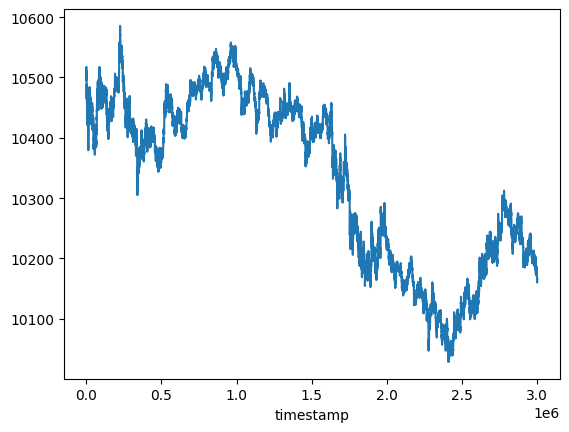

In [74]:
ROCK['mid_price'].plot()

In [75]:
ROCK['mid_price'].pct_change().std() * np.sqrt(10000)

0.025029613564150396

In [ ]:
ROCK['mid_price'].pct_change().iloc[:5000].std() * np.sqrt(10000)

In [428]:
def brent(f, a, b, tol=1e-10, max_iter=1000):
    """
    Brent's method to find a root of f in the interval [a, b]
    
    Parameters:
        f        : function for which to find the root
        a, b     : interval endpoints (must bracket the root)
        tol      : desired tolerance
        max_iter : maximum number of iterations
        
    Returns:
        root     : approximate root of f
    """
    fa = f(a)
    fb = f(b)
    
    if fa * fb > 0:
        raise ValueError("Function must have opposite signs at endpoints a and b.")
    
    if abs(fa) < abs(fb):
        a, b = b, a
        fa, fb = fb, fa

    c, fc = a, fa
    d = e = b - a

    for _ in range(max_iter):
        if fb == 0:
            return b
        
        if fa != fc and fb != fc:
            # Inverse quadratic interpolation
            s = (a * fb * fc) / ((fa - fb) * (fa - fc)) \
              + (b * fa * fc) / ((fb - fa) * (fb - fc)) \
              + (c * fa * fb) / ((fc - fa) * (fc - fb))
        else:
            # Secant method
            s = b - fb * (b - a) / (fb - fa)

        conditions = [
            not (3 * a + b) / 4 < s < b if b > a else not b < s < (3 * a + b) / 4,
            (e is not None and abs(s - b) >= abs(e) / 2),
            (d is not None and abs(e) < tol),
            (d is not None and abs(fa) <= abs(fb)),
        ]

        if any(conditions):
            s = (a + b) / 2
            e = d = b - a
        else:
            d = e
            e = b - s

        fs = f(s)
        c, fc = b, fb

        if fa * fs < 0:
            b = s
            fb = fs
        else:
            a = s
            fa = fs

        if abs(fa) < abs(fb):
            a, b = b, a
            fa, fb = fb, fa

        if abs(b - a) < tol:
            return b

    raise RuntimeError("Maximum number of iterations reached without convergence.")


In [436]:
def BS_CALL(S, K, T, r, sigma):
    N = NormalDist().cdf
    d1 = (math.log(S/K) + (r + sigma**2/2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    print(d1 ,d2)
    return S * N(d1) - K * math.exp(-r*T) * N(d2)


In [ ]:



def vega(S, K, T, r, sigma):
    '''

    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    '''

    ### calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))

    N_prime = NormalDist().pdf
    vega = S  * np.sqrt(T) * N_prime(d1)
    return vega

In [ ]:
def implied_volatility_call( S, K, T, r,C,tol=0.0001,
                            max_iterations=100):

    ### assigning initial volatility estimate for input in Newton_rap procedure
    sigma = 0.001

    for i in range(max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = BS_CALL(S, K, T, r, sigma) - C

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
            break

        ### use newton rapshon to update the estimate
        sigma = sigma - diff / vega(S, K, T, r, sigma)

    return sigma

In [ ]:
def get_implied_volatility(S, K, T, r, market_price):
    # Define the objective function to minimize
    def objective_function(sigma):
        return BS_CALL(S, K, T, r, sigma) - market_price

    implied_vol = brent(objective_function, 1e-8, 1)
    return implied_vol

In [ ]:
S = 10500
K = 10500
T = 8
r = 0
sigma = 0.0084
round(BS_CALL(S, K, T, r, sigma))

<Axes: title={'center': 'Rolling realized volatility'}, xlabel='timestamp'>

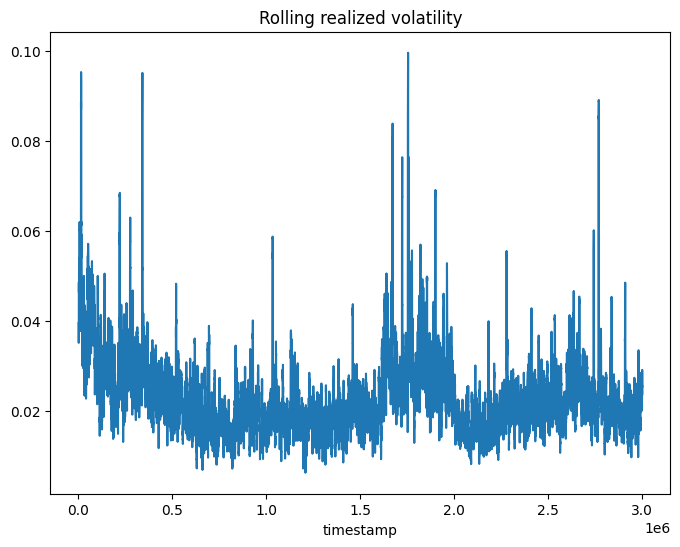

In [82]:
(ROCK['mid_price'].pct_change().rolling(20).std() * np.sqrt(10000)).plot(title='Rolling realized volatility', figsize=(8,6)) 

In [ ]:
S = 10500
K = 9750
T = 8 - pd.Series(ROCK.index)/1000000

In [437]:
i = 30000-1
print(ROCK['mid_price'].iloc[i],  9500, T.iloc[i], 0, V_9500['mid_price'].iloc[i])
# get_implied_volatility(ROCK['mid_price'].iloc[i],  9500, T.iloc[i], 0, V_9500['mid_price'].iloc[i])
print(BS_CALL(ROCK['mid_price'].iloc[i],  9500, T.iloc[i]*5, 0, 0.001))


10166.5 9500 5.0001 0 666.5
13.56360496698136 13.558604916981611
666.5


In [444]:
NormalDist().cdf(5)

0.9999997133484282

In [402]:
d = dict()
v_prices = {9500 : V_9500, 9750 : V_9750, 10000 : V_10000, 10250 : V_10250, 10500 : V_10500}
for k,v in v_prices.items():
    sigma_list = []
    for i in range(len(ROCK)):
        try:
            sigma = get_implied_volatility(ROCK['mid_price'].iloc[i],  k, T.iloc[i], 0, v['mid_price'].iloc[i])
            # sigma = implied_volatility_call(ROCK['mid_price'].iloc[i],  k, T.iloc[i], 0, v['mid_price'].iloc[i])
        except:
            sigma = np.nan
        sigma_list.append(sigma)
    d[k] = sigma_list
d['ROCK'] = np.log(ROCK['mid_price']).diff().rolling(100).std() * np.sqrt(10000)

In [403]:
sigma_df = pd.DataFrame(d)
sigma_df.index = ROCK.index
# sigma_df = sigma_df[sigma_df>0.0001]

In [404]:
def moving_average(series, window):
    """Calculate the moving average of a time series."""
    return series.rolling(window=window).mean()

In [406]:
sigma_df[9500]#.plot()#.count()

timestamp
0          0.013473
100        0.013553
200        0.013587
300        0.013638
400        0.013547
             ...   
2999500         NaN
2999600    0.012046
2999700    0.012046
2999800         NaN
2999900         NaN
Name: 9500, Length: 30000, dtype: float64

<Axes: xlabel='timestamp'>

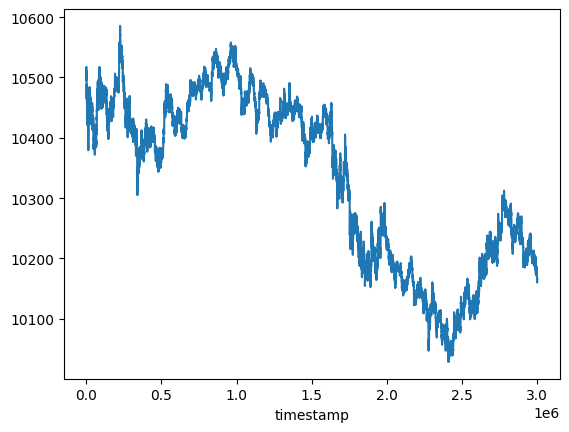

In [100]:
ROCK['mid_price'].plot()

<Axes: title={'center': 'Implied volatility'}, xlabel='timestamp'>

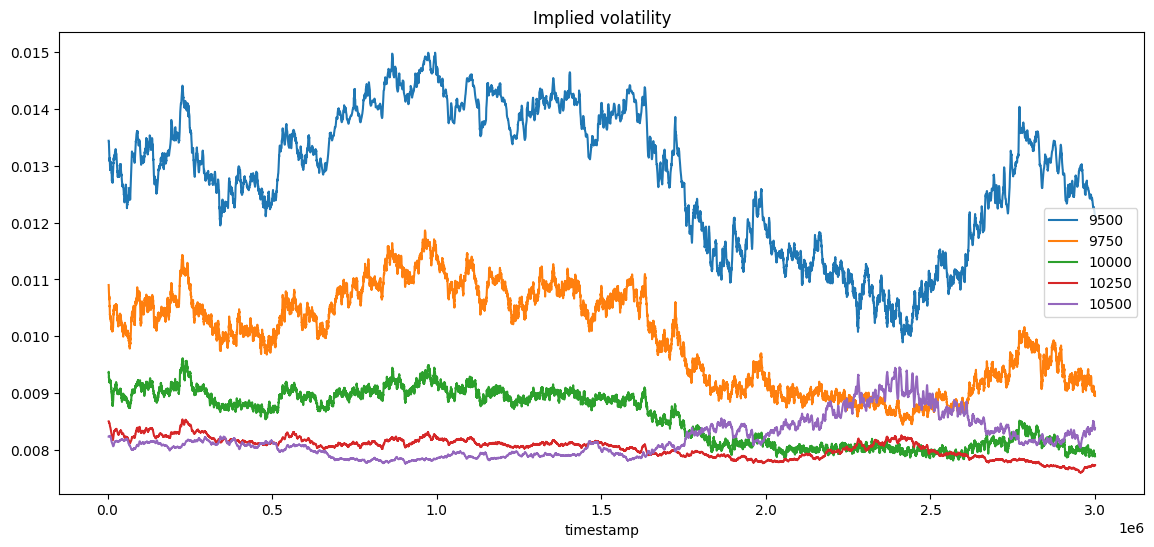

In [105]:
fig = sigma_df.iloc[:,:5].ffill().pipe(moving_average,35).plot(title='Implied volatility', figsize=(14,6))
# fig.update_yaxes(type="log")
fig

<Axes: title={'center': 'S'}, xlabel='timestamp'>

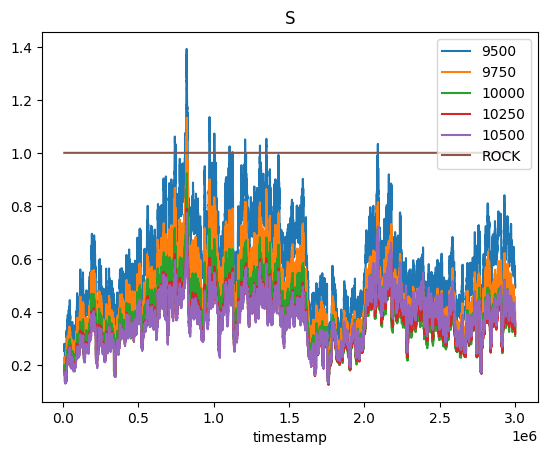

In [93]:
sigma_df.ffill().pipe(lambda x: x.div(x['ROCK'],axis=0)).plot(title='S')#.pipe(lambda x: x.div(x['ROCK'],axis=0)).

In [108]:
T.index = V_10000.index
m_10500 = (np.log(10500/ROCK['mid_price'])/np.sqrt(T)).rename('m_10500')
m_9500 = (np.log(9500/ROCK['mid_price'])/np.sqrt(T)).rename('m_9500')
m_9750 = (np.log(9750/ROCK['mid_price'])/np.sqrt(T)).rename('m_9750')
m_10250 = (np.log(10250/ROCK['mid_price'])/np.sqrt(T)).rename('m_10250')
m_10000 = (np.log(10000/ROCK['mid_price'])/np.sqrt(T)).rename('m_10000')

In [122]:
#scatter plot mt and sigmadf
df = pd.concat([sigma_df.ffill(), m_10000, m_10250, m_10500, m_9500, m_9750], axis=1)#.iloc[5000:]
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df['m_10000'], y=df[10000], mode='markers', name='m_10000'))
# fig.add_trace(go.Scatter(x=df['m_10250'], y=df[10250], mode='markers', name='m_10250'))
# fig.add_trace(go.Scatter(x=df['m_10500'], y=df[10500], mode='markers', name='m_10500'))
# fig.add_trace(go.Scatter(x=df['m_9500'], y=df[9500], mode='markers', name='m_9500'))
# fig.add_trace(go.Scatter(x=df['m_9750'], y=df[9750], mode='markers', name='m_9750'))

In [123]:
df

9500      9750     10000     10250     10500      ROCK  \
timestamp                                                               
0          0.013473  0.011780  0.008897  0.008539  0.008270       NaN   
100        0.013553  0.011871  0.010350  0.008547  0.008219       NaN   
200        0.013587  0.011909  0.009567  0.008611  0.008255       NaN   
300        0.013638  0.011356  0.009865  0.008483  0.008223       NaN   
400        0.013547  0.011257  0.009266  0.008609  0.008241       NaN   
...             ...       ...       ...       ...       ...       ...   
2999500    0.011938  0.007873  0.007542  0.007685  0.008419  0.024330   
2999600    0.012046  0.009128  0.008038  0.007725  0.008440  0.024305   
2999700    0.012046  0.009128  0.007692  0.007725  0.008440  0.023929   
2999800    0.012046  0.008613  0.008138  0.007705  0.008430  0.023944   
2999900    0.012046  0.008596  0.007408  0.007745  0.008451  0.023944   

            m_10000   m_10250   m_10500    m_9500    m_9750  
timestamp                                                    
0         -0.017351 -0.008621 -0.000101 -0.035486 -0.026302  
100       -0.017587 -0.008856 -0.000337 -0.035722 -0.026538  
200       -0.017688 -0.008957 -0.000437 -0.035823 -0.026639  
300       -0.017839 -0.009109 -0.000589 -0.035974 -0.026790  
400       -0.017570 -0.008840 -0.000320 -0.035705 -0.026522  
...             ...       ...       ...       ...       ...  
2999500   -0.007450  0.003592  0.014368 -0.030388 -0.018772  
2999600   -0.007406  0.003636  0.014412 -0.030345 -0.018729  
2999700   -0.007407  0.003636  0.014412 -0.030345 -0.018729  
2999800   -0.007429  0.003614  0.014391 -0.030367 -0.018751  
2999900   -0.007385  0.003658  0.014435 -0.030324 -0.018707  

[30000 rows x 11 columns]

In [124]:

y = pd.concat([df[10000],df[10250],df[10500],df[9500],df[9750]], axis=0).fillna(0)
X = pd.concat([df['m_10000'],df['m_10250'],df['m_10500'],df['m_9500'],df['m_9750']], axis=0)

In [114]:
#fit a parabolic curve to the data
import numpy as np
from scipy.optimize import curve_fit
def parabolic(x, a, b, c):
    return a * x**2 + b * x + c
# Fit the curve to the data
popt, pcov = curve_fit(parabolic, X, y)
# Generate x values for the fitted curve
x_fit = np.linspace(X.min(), X.max(), 100)
# Generate y values for the fitted curve
y_fit = parabolic(x_fit, *popt)
# Add the fitted curve to the plot
fig.add_trace(go.Scatter(x=x_fit, y=y_fit, mode='lines', name='Fitted Curve'))

AttributeError: 'Axes' object has no attribute 'add_trace'

In [125]:
def base_iv(x):
    return parabolic(x, *popt)

In [118]:
df[[10000, 10250, 10500, 9500, 9750]].ffill().div(df[[10000, 10250, 10500, 9500, 9750]].iloc[1], axis=1)

10000     10250     10500      9500      9750
timestamp                                                  
500000     0.999993  0.999993  0.999993  0.999501  0.908476
500100     1.000000  1.000000  1.000000  1.000000  1.000000
500200     1.005124  1.002795  0.990705  1.002434  0.837914
500300     1.052732  1.003693  0.996296  1.002434  0.909716
500400     1.053797  1.011919  0.994443  1.001477  0.961348
...             ...       ...       ...       ...       ...
2999500    0.880360  0.951184  1.031097  0.963611  0.725136
2999600    0.938294  0.956088  1.033662  0.972361  0.840652
2999700    0.897861  0.956098  1.033672  0.972370  0.840660
2999800    0.949944  0.953661  1.032405  0.972370  0.793236
2999900    0.864731  0.958560  1.034970  0.972370  0.791648

[25000 rows x 5 columns]

In [127]:
# df[[10000, 10250, 10500, 9500, 9750]].ffill().div(df[[10000, 10250, 10500, 9500, 9750]].iloc[1], axis=1).iloc[::10].dropna(how='all').plot(backend='plotly', title='S')

In [129]:
df = pd.concat([sigma_df.ffill(), m_10000, m_10250, m_10500, m_9500, m_9750], axis=1).drop('ROCK',axis=1).dropna()

In [130]:
#fit parabolic curve to each row
def fit_parabolic_curve(row):
    x = row[['m_10000', 'm_10250', 'm_10500', 'm_9500', 'm_9750']].values
    y = row[[10000, 10250, 10500, 9500, 9750]].values
    popt, _ = curve_fit(parabolic, x, y)
    return pd.Series(popt)

In [161]:
c = df.apply(fit_parabolic_curve, axis=1)

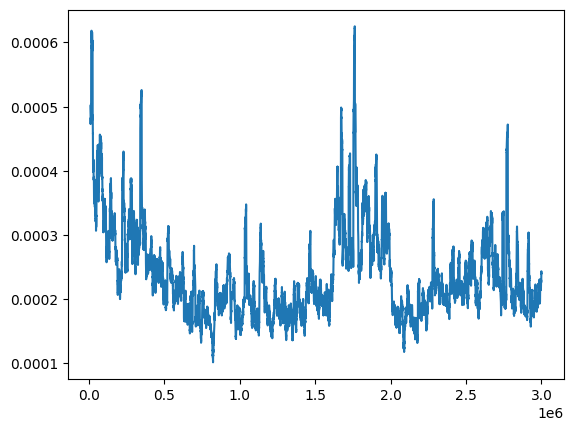

<Axes: title={'center': 'Realized volatility'}, xlabel='timestamp'>

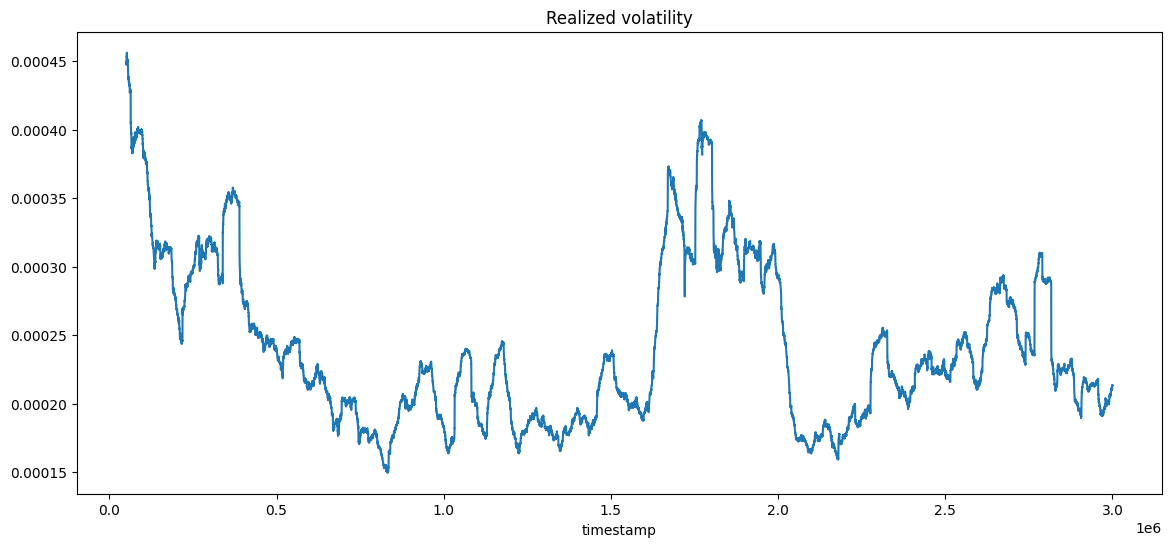

In [201]:
ROCK['mid_price'].pct_change().rolling(500).std().dropna().plot(figsize=(14,6), title='Realized volatility')

In [388]:
sigma_df[9500]#.count()

timestamp
0          0.013473
100        0.013553
200        0.013587
300        0.013638
400        0.013547
             ...   
2999500         NaN
2999600    0.012046
2999700    0.012046
2999800         NaN
2999900         NaN
Name: 9500, Length: 30000, dtype: float64

In [379]:
sigma_df.head()

9500      9750     10000     10250     10500  ROCK
timestamp                                                        
0          0.013473  0.011780  0.008897  0.008539  0.008270   NaN
100        0.013553  0.011871  0.010350  0.008547  0.008219   NaN
200        0.013587  0.011909  0.009567  0.008611  0.008255   NaN
300        0.013638  0.011356  0.009865  0.008483  0.008223   NaN
400        0.013547  0.011257  0.009266  0.008609  0.008241   NaN

<Axes: title={'center': 'Implied volatility'}, xlabel='timestamp'>

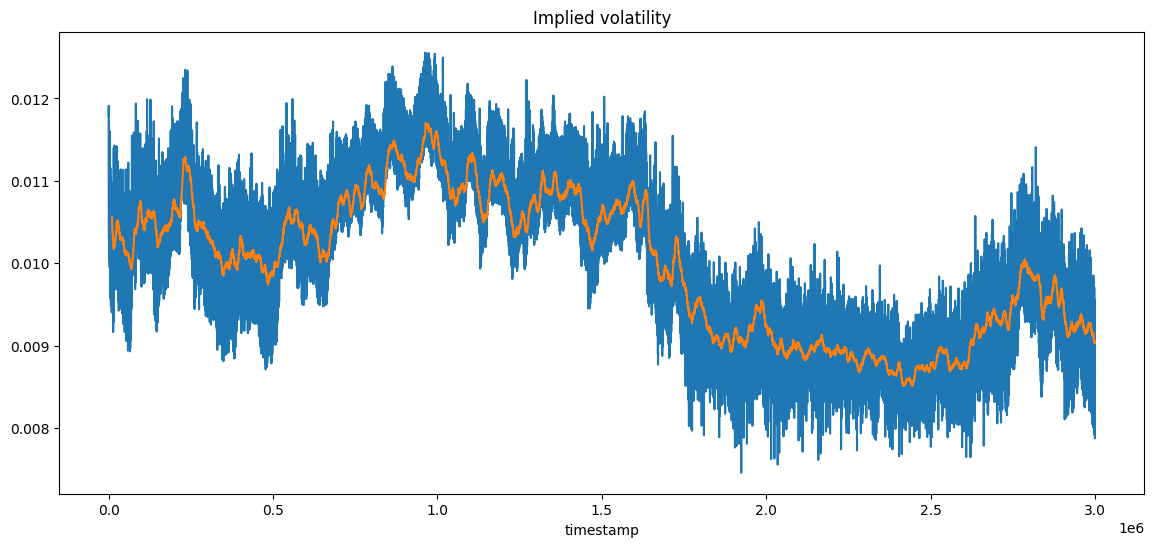

In [385]:
fig = sigma_df.iloc[:,1].ffill().pipe(moving_average,1).plot(title='Implied volatility', figsize=(14,6))
plt.plot(sigma_df.iloc[:,1].ffill().pipe(moving_average,100))
fig

<Axes: title={'center': 'Implied volatility'}, xlabel='timestamp'>

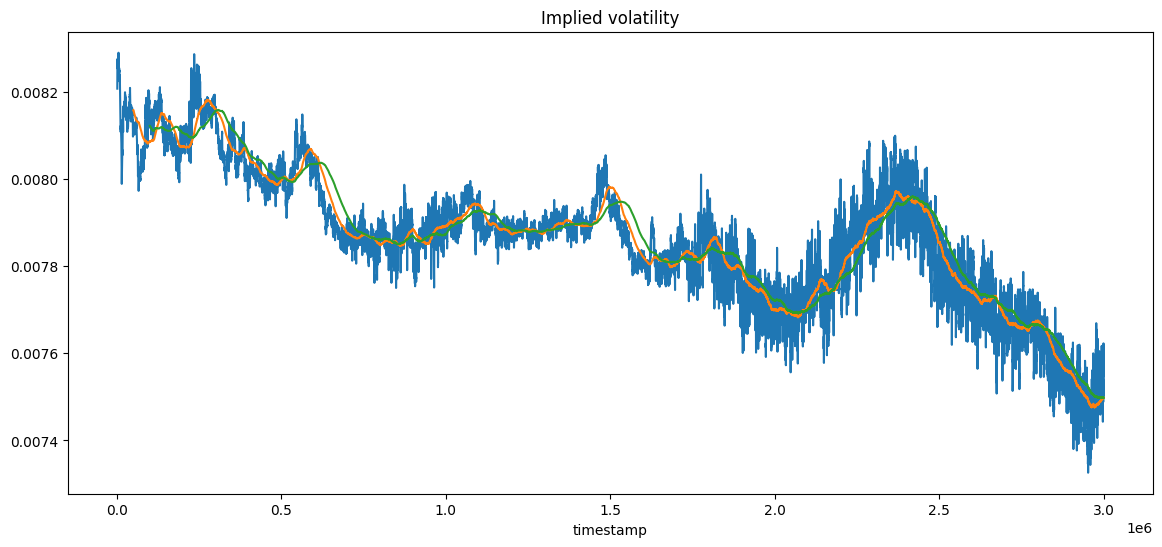

In [206]:
fig = c[2].pipe(moving_average,11).plot(figsize=(14,6), title='Implied volatility')
# plt.plot(c[2].pipe(moving_average,100))

plt.plot(c[2].pipe(moving_average,500))
plt.plot(c[2].pipe(moving_average,1000))

fig

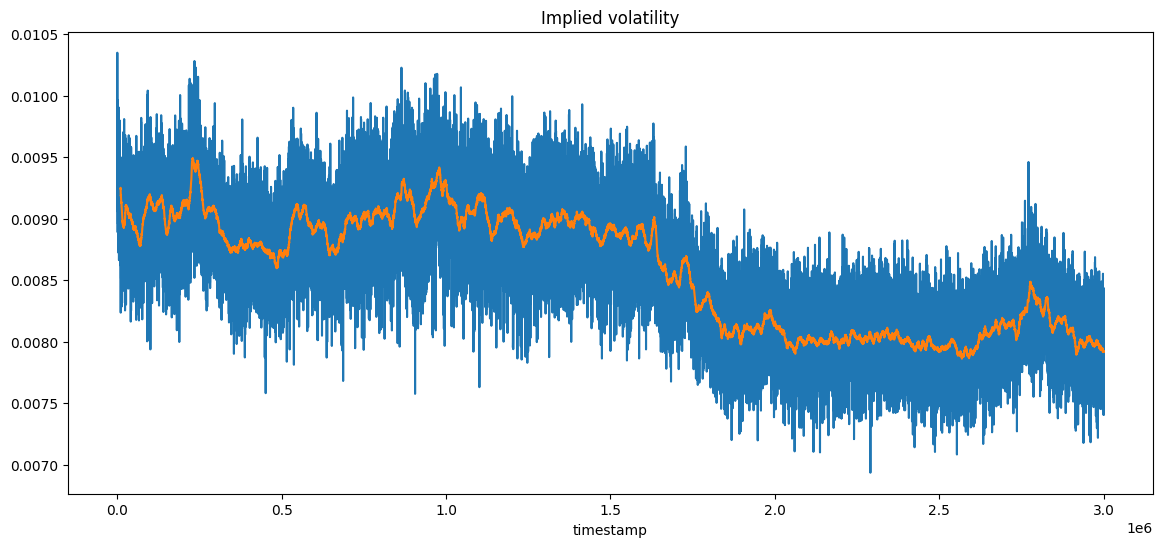

In [147]:
sigma_df[10000].plot(title='Implied volatility', figsize=(14,6))
plt.plot(sigma_df[10000].pipe(moving_average,100))

In [370]:
T = 8 - pd.Series(ROCK.index)/1000000
T.index = ROCK.index
S = ROCK['mid_price']
predicted_price = []
K = 9750
for row in df[[K]].rolling(1000).mean().iterrows():
    t = T.loc[row[0]]
    sigma = row[1].iloc[0]
    s = S.loc[row[0]]
    predicted_price.append(BS_CALL(s, K, t, 0, sigma))
predicted_price = pd.Series(predicted_price, index=df.index, name=f'predicted_price {K}')
    


In [372]:
predicted_price.plot(backend='plotly')

In [445]:
(V_9750['mid_price'] - predicted_price).plot(backend='plotly')

In [469]:
(ROCK['mid_price']-10250).apply(lambda x: max(0,x))

timestamp
0          253.0
100        260.0
200        263.0
300        267.5
400        259.5
           ...  
2999500      0.0
2999600      0.0
2999700      0.0
2999800      0.0
2999900      0.0
Name: mid_price, Length: 30000, dtype: float64

In [468]:
(V_10250['mid_price'] - (ROCK['mid_price']-10250).apply(lambda x: max(0,x))).pipe(moving_average,1).plot(backend='plotly')

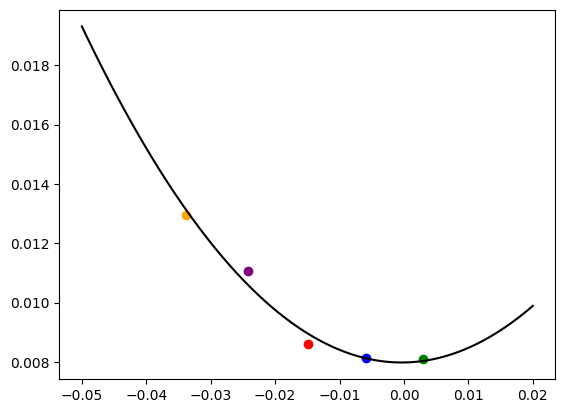

In [ ]:
i = 6000
a, b, d = c.iloc[i][0], c.iloc[i][1], c.iloc[i][2]
def f(x, a, b, d):
    return a * x**2 + b * x + d

plt.scatter(df.iloc[i]['m_10000'], df.iloc[i][10000], color='red')
plt.scatter(df.iloc[i]['m_10250'], df.iloc[i][10250], color='blue')
plt.scatter(df.iloc[i]['m_10500'], df.iloc[i][10500], color='green')
plt.scatter(df.iloc[i]['m_9500'], df.iloc[i][9500], color='orange')
plt.scatter(df.iloc[i]['m_9750'], df.iloc[i][9750], color='purple')
x = np.linspace(-0.05, 0.02, 100)
plt.plot(x, f(x), color='black')


In [169]:
df

9500      9750     10000     10250     10500   m_10000  \
timestamp                                                               
0          0.013473  0.011780  0.008897  0.008539  0.008270 -0.017351   
100        0.013553  0.011871  0.010350  0.008547  0.008219 -0.017587   
200        0.013587  0.011909  0.009567  0.008611  0.008255 -0.017688   
300        0.013638  0.011356  0.009865  0.008483  0.008223 -0.017839   
400        0.013547  0.011257  0.009266  0.008609  0.008241 -0.017570   
...             ...       ...       ...       ...       ...       ...   
2999500    0.011938  0.007873  0.007542  0.007685  0.008419 -0.007450   
2999600    0.012046  0.009128  0.008038  0.007725  0.008440 -0.007406   
2999700    0.012046  0.009128  0.007692  0.007725  0.008440 -0.007407   
2999800    0.012046  0.008613  0.008138  0.007705  0.008430 -0.007429   
2999900    0.012046  0.008596  0.007408  0.007745  0.008451 -0.007385   

            m_10250   m_10500    m_9500    m_9750  
timestamp                                          
0         -0.008621 -0.000101 -0.035486 -0.026302  
100       -0.008856 -0.000337 -0.035722 -0.026538  
200       -0.008957 -0.000437 -0.035823 -0.026639  
300       -0.009109 -0.000589 -0.035974 -0.026790  
400       -0.008840 -0.000320 -0.035705 -0.026522  
...             ...       ...       ...       ...  
2999500    0.003592  0.014368 -0.030388 -0.018772  
2999600    0.003636  0.014412 -0.030345 -0.018729  
2999700    0.003636  0.014412 -0.030345 -0.018729  
2999800    0.003614  0.014391 -0.030367 -0.018751  
2999900    0.003658  0.014435 -0.030324 -0.018707  

[30000 rows x 10 columns]